# Optimizing M for $\star_M$ Algebra via SDP

This notebook tests the proposed algorithm on a GIF of a moving escalator. Here are some frames of the data:

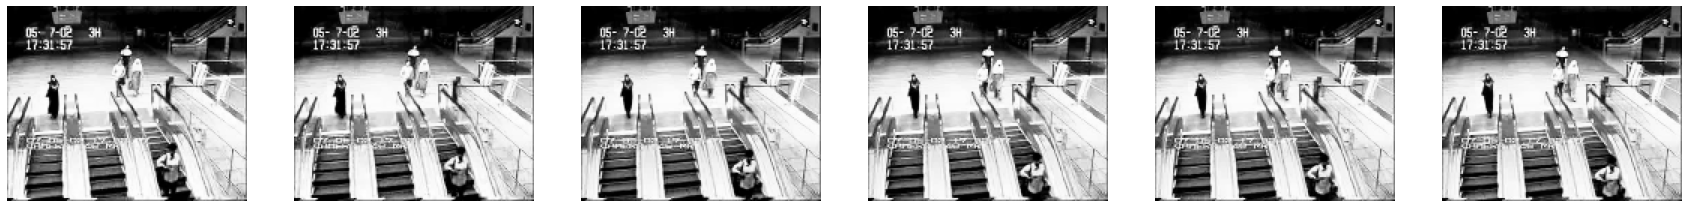

In [40]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt 
from scipy.fftpack import dct, fft, ifft

data_tensor = np.load("data/Escalator.npy") / 255
m, n, p = data_tensor.shape
data_pinv = np.linalg.pinv(data_tensor.reshape((m*n, p)))

for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(1-data_tensor[:, i], cmap="Greys")
    plt.axis('off')
plt.gcf().set_size_inches(30, 5)
plt.show()

def dctmtx(n, normalize=False):
    d = dct(np.eye(n), axis=0)
    if (normalize):
        d = d / np.sqrt(np.sum(d ** 2, axis=1)).reshape((-1, 1))
    return d

D = dctmtx(p, normalize=True)

In [3]:
def solve_m(M_k, data, data_pinv):
    R = cp.Variable((m, n))
    W1 = cp.Variable((m, m))
    W2 = cp.Variable((n, n))
    S = cp.atoms.affine.bmat.bmat([[W1, R], [R.T, W2]])
    
    def assert_ortho(R, mi):
        return cp.trace(R.T @ (mi[None, :] @ data_pinv).reshape((m, n))) == 0
    
    def assert_norm(R):
        return cp.sum(data_pinv @ cp.atoms.affine.reshape.reshape(R, (m*n, 1)), 1) >= 1
    
    constraints = [S >> 0] + [assert_norm(R)] + [assert_ortho(R, mi) for mi in M_k.T]
    prob = cp.Problem(cp.Minimize(cp.trace(S)), constraints)
    prob.solve()
    m_kp1 = data_pinv @ R.value.reshape(m*n, 1)
    return m_kp1

In [94]:
'''
M = np.zeros((p, 1))

for i in range(1, p+1):
    M = np.concatenate((M, solve_m(M, data_tensor, data_pinv)), axis=1)
    print(f"Optimized column {i}/{p}...")
M = M[:, 1:]
'''

M = np.load("M.npy")
M = M / np.linalg.norm(M, axis=0)[None, :]
M = np.linalg.qr(M)[0] # numerical optimization error yields <M_i, M_j> approx 1e-7, we round this off

In [95]:
def x3(X, M):
    m, n, p = X.shape
    return (X.reshape((m*n, p)) @ M).reshape((m, n, p))

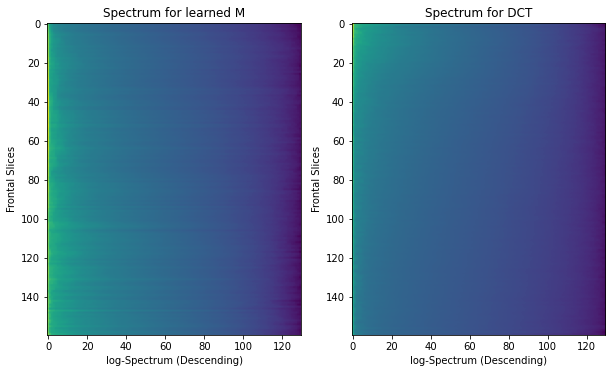

In [96]:
plt.subplot(1, 2, 1)
plt.title("Spectrum for learned M")
plt.xlabel("log-Spectrum (Descending)")
plt.ylabel("Frontal Slices")
S = np.stack([np.linalg.svd(x3(data_tensor, M)[:, :, i])[1] for i in range(p)], axis=0)
plt.imshow(np.log(S))

plt.subplot(1, 2, 2)
plt.title("Spectrum for DCT")
plt.xlabel("log-Spectrum (Descending)")
plt.ylabel("Frontal Slices")
S_control = np.stack([np.linalg.svd(x3(data_tensor, D)[:, :, i])[1] for i in range(p)], axis=0)
plt.imshow(np.log(S_control))

plt.gcf().set_size_inches(10, 7)
plt.show()

In [ ]:
def truncate_spectrum(target_rank, M, X):
    m, n, p = X.shape
    r = min(m, n)
    X_hat = x3(X, M)
    U, S, Vt = np.linalg.svd(X_hat.transpose((2, 0, 1)), full_matrices=False)
    mask = np.zeros((r,))
    mask[:target_rank] = 1
    truncate_faces = [U[i] @ np.diag(S[i] * mask) @ Vt[i] for i in range(p)]
    return x3(np.stack(truncate_faces, axis=2), M.T)

def psnr(X, Xhat):
    return -10 * np.log( np.mean((X-Xhat)**2) ) / np.log(10)


truncation = np.linspace(1, p, 30).astype(np.int)
learned_errs = [ psnr(data_tensor, truncate_spectrum(r, M, data_tensor)) for r in truncation]
dct_errs = [ psnr(data_tensor, truncate_spectrum(r, D, data_tensor)) for r in truncation]

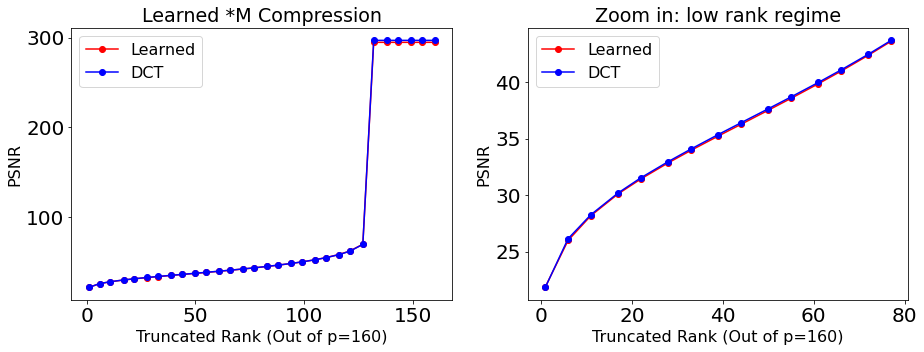

In [109]:
plt.rcParams.update({'font.size': 16})

plt.subplot(1, 2, 1)
plt.plot(truncation, learned_errs, "ro-", label="Learned")
plt.plot(truncation, dct_errs, "bo-", label="DCT")
plt.xlabel(f"Truncated Rank (Out of p={p})")
plt.ylabel("PSNR")
plt.title("Learned *M Compression")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(truncation[:15], learned_errs[:15], "ro-", label="Learned")
plt.plot(truncation[:15], dct_errs[:15], "bo-", label="DCT")
plt.xlabel(f"Truncated Rank (Out of p={p})")
plt.ylabel("PSNR")
plt.title("Zoom in: low rank regime")
plt.legend()
plt.gcf().set_size_inches(15, 5)
plt.show()
    

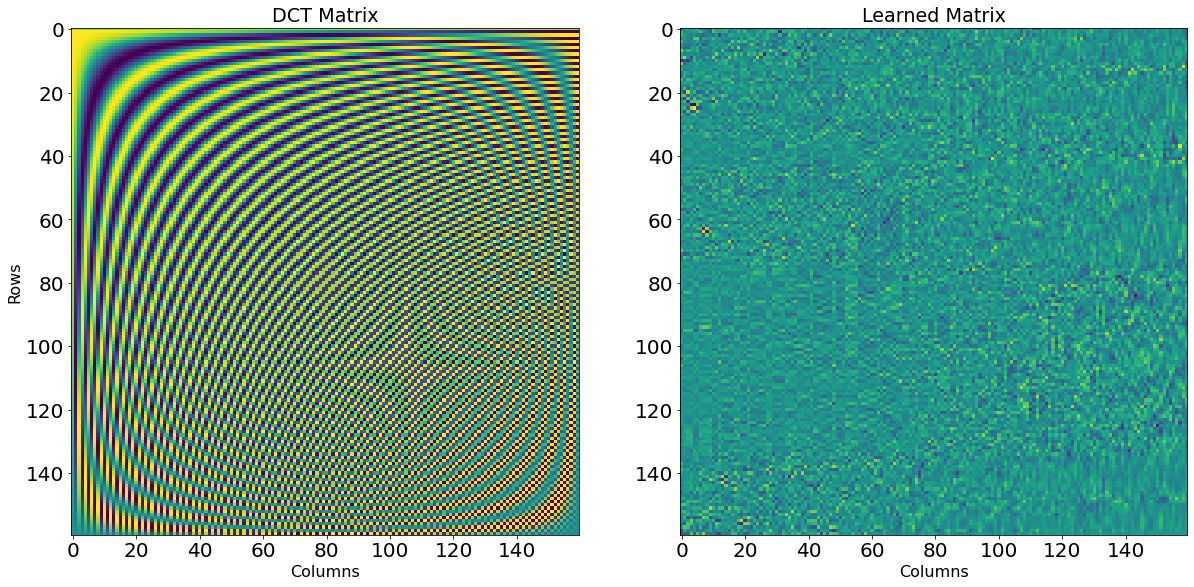

In [110]:
plt.subplot(1, 2, 1)
plt.title("DCT Matrix")
plt.imshow(D)
plt.ylabel("Rows")
plt.xlabel("Columns")
plt.subplot(1, 2, 2)
plt.title("Learned Matrix")
plt.imshow(M)
plt.xlabel("Columns")
plt.gcf().set_size_inches(20, 10)
plt.show()